In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
# pl.rcParams['xtick.labelsize'] = 7
# pl.rcParams['ytick.labelsize'] = 7
# pl.rcParams['axes.labelsize'] = 7
# pl.rcParams['axes.titlesize'] = 5
# pl.rcParams['legend.fontsize'] = 5
# pl.rcParams['xtick.labelsize'] = 5
# pl.rcParams['ytick.labelsize'] = 5
# pl.rcParams['font.size'] = 7

# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
NOTEBOOK_NAME = 'decoding_combined_vhpc_1sec'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
#all_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m6', 'c10m8', '90', '91', '92','93'
#expo_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92','93'
#pre_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92','93'
#post_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92','93'
#renew_animals ='c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m6', 'c10m8', '90', '91', '92','93'
#ext2_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m6', 'c10m8', '90', '91', '92','93'
#ext1_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92','93'

all_animals  = np.loadtxt('../allmice.txt', dtype=str)
expo_animals = np.loadtxt('../expo_mice.txt', dtype=str)
pre_animals  = np.loadtxt('../pre_mice.txt', dtype=str)
d2_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
post_animals = np.loadtxt('../post_mice.txt', dtype=str)
renew_animals= np.loadtxt('../renew_mice.txt', dtype=str)
ext2_animals = np.loadtxt('../ext2_mice.txt', dtype=str)
ext1_animals = np.loadtxt('../ext1_mice.txt', dtype=str)

In [8]:
sessions = 'pre','d2', 'post', 'ext1', 'ext2', 'renew'

In [9]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_within(patterns, labels, n_cells=None):
#     which_train = range(90)
#     which_test = range(90)
    cv = LeaveOneOut()
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        print cells.shape,
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    return decoder.score(patterns_comb_test[:, cells], labels_comb)

In [10]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [11]:
for sess in 'pre','d2', 'post', 'ext1', 'ext2', 'renew':

    exec("patterns_CS_%s = dict(zip(%s_animals, [ut.load_variable('patterns_CS_evs_%s_1s',\
                                                           '../%%s/notebooks/autorestore/decoding_all/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_CS_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                         '../%%s/notebooks/autorestore/decoding_all/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [12]:
##have to extract 2_odor_expo varibles differently from that used above
#patterns_CS_expo = dict(zip(expo_animals,
#                                [ut.load_variable('patterns_evs_1s','../%s/2_odor_expo/notebooks/autorestore/decoding_odors'%ani)
#                                                  for ani in expo_animals]))
#
#labels_CS_expo = dict(zip(expo_animals,
#                                [ut.load_variable('labels','../%s/2_odor_expo/notebooks/autorestore/decoding_odors'%ani)
#                                                  for ani in expo_animals]))

In [13]:
#set downsampling parameter to:
#max_cells = all cells
#intraregion_min = downsample to the comparison with fewest cells within the same hippo region
#interregion_min = downsample to the comparison with fewest cells, considering both hippo regions
#gmin = the global minimum (pretty much corresponds to interregion_min)
#230 = well, 230 cells (any sessions with < 230 cells will just use however many cells they have)

downsample = 'intraregion_min'

In [14]:
if downsample == 'max_cells':
    n_cells = None #will use all registered cells
if downsample == 'intraregion_min':
    n_cells = ut.load_variable('n_cells_within_min_vhpc', '../notebooks/autorestore/n_cells/')
if downsample == 'interregion_min':
    n_cells = ut.load_variable('n_cells_within_min_overall', '../notebooks/autorestore/n_cells/')
if downsample == 'gmin':
    n_cells = ut.load_variable('n_cells_gmin', '../notebooks/autorestore/n_cells/')
if downsample == '230':
    n_cells = 230

In [15]:
n_cells

454

In [16]:
scores_CS = {}
n_loops = 50
for sess in sessions:
    scores_CS[sess] = np.r_[[do_test_within(eval("patterns_CS_%s"%sess), eval("labels_CS_%s"%sess), n_cells=n_cells)
                          for i in range(n_loops)]]

(454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,)

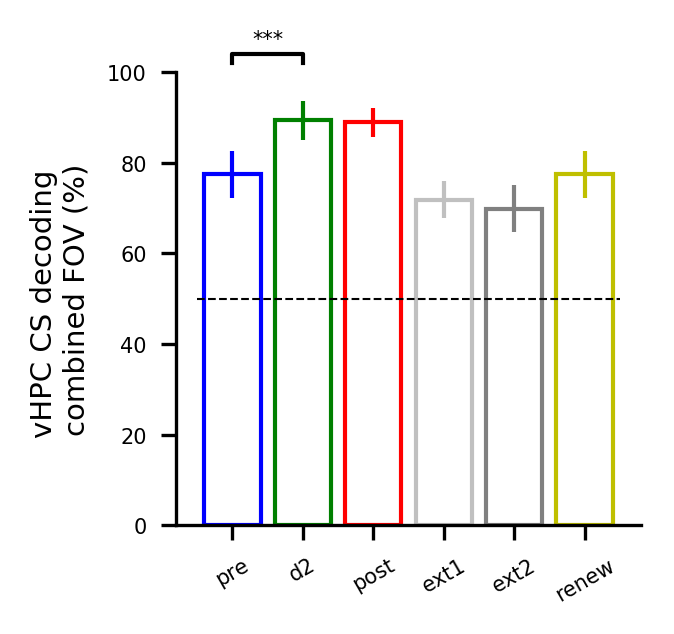

In [17]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
values = [scores_CS[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','g','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('vHPC CS decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
#pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


fig.savefig('../img/%s__bars_CS_vhpc.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s__bars_CS_vhpc.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [22]:
for sess in 'pre','d2', 'post', 'ext1', 'ext2', 'renew':

    exec("patterns_tr_%s = dict(zip(%s_animals, [ut.load_variable('patterns_evs_%s_1s',\
                                                           '../%%s/notebooks/autorestore/decoding_all/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_tr_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                         '../%%s/notebooks/autorestore/decoding_all/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [23]:
##have to extract 2_odor_expo varibles differently from that used above
#patterns_tr_expo = dict(zip(expo_animals,
#                                [ut.load_variable('patterns_evs','../%s/2_odor_expo/notebooks/autorestore/decoding_odors_only_trace'%ani)
#                                                  for ani in expo_animals]))
#
#labels_tr_expo = dict(zip(expo_animals,
#                                [ut.load_variable('labels','../%s/2_odor_expo/notebooks/autorestore/decoding_odors_only_trace'%ani)
#                                                  for ani in expo_animals]))

In [24]:
scores_tr = {}
n_loops = 50
for sess in sessions:
    scores_tr[sess] = np.r_[[do_test_within(eval("patterns_tr_%s"%sess), eval("labels_tr_%s"%sess), n_cells=n_cells)
                          for i in range(n_loops)]]

(454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,) (454,)

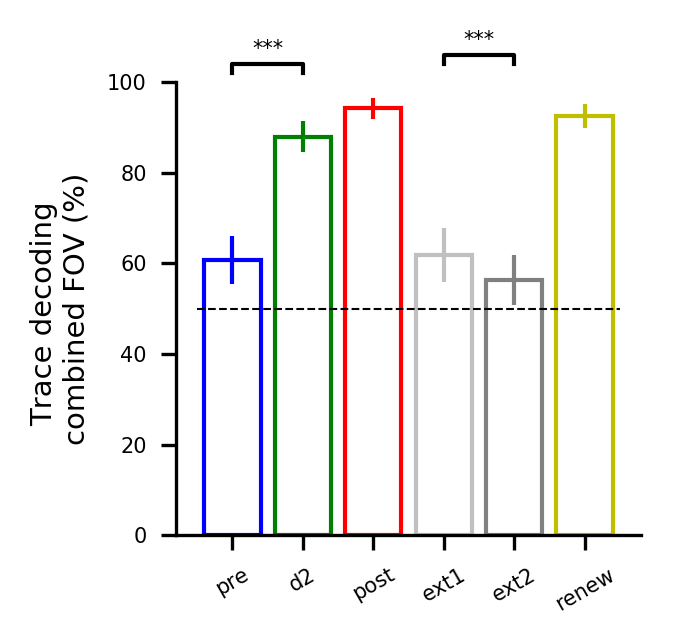

In [25]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
values = [scores_tr[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','g','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('Trace decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


fig.savefig('../img/%s_tr_bars_vhpc.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s_tr_bars_vhpc.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [26]:
total_cells_pre = sum(len(patterns_tr_pre[ani][0]) for ani in pre_animals)
print 'total_cells_pre = ',
print total_cells_pre

total_cells_d2 = sum(len(patterns_tr_d2[ani][0]) for ani in d2_animals)
print 'total_cells_d2 = ',
print total_cells_d2

total_cells_post = sum(len(patterns_tr_post[ani][0]) for ani in post_animals)
print 'total_cells_post = ',
print total_cells_post

total_cells_ext1 = sum(len(patterns_tr_ext1[ani][0]) for ani in ext1_animals)
print 'total_cells_ext1 = ',
print total_cells_ext1

total_cells_ext2 = sum(len(patterns_tr_ext2[ani][0]) for ani in ext2_animals)
print 'total_cells_ext2 = ',
print total_cells_ext2

total_cells_renew = sum(len(patterns_tr_renew[ani][0]) for ani in renew_animals)
print 'total_cells_renew = ',
print total_cells_renew

total_cells_pre =  521
total_cells_d2 =  568
total_cells_post =  454
total_cells_ext1 =  475
total_cells_ext2 =  518
total_cells_renew =  473


# now use gmin

In [27]:
gmin_cells = ut.load_variable('n_cells_gmin', '../notebooks/autorestore/n_cells/')
print gmin_cells

147


In [28]:
scores_CS_gmin = {}
n_loops = 50
for sess in sessions:
    scores_CS_gmin[sess] = np.r_[[do_test_within(eval("patterns_CS_%s"%sess), eval("labels_CS_%s"%sess), n_cells=gmin_cells)
                          for i in range(n_loops)]]

(147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,)

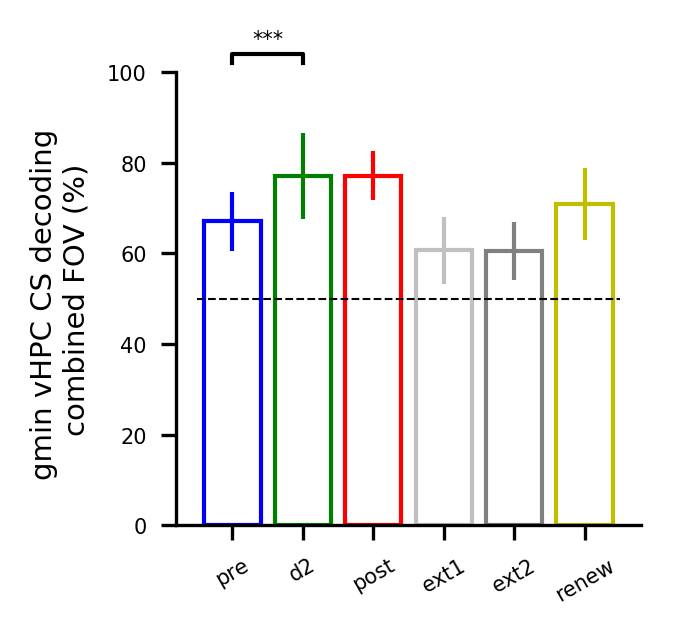

In [30]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
values = [scores_CS_gmin[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','g','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('gmin vHPC CS decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
#pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


fig.savefig('../img/%s__bars_CS_vhpc_gmin.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s__bars_CS_vhpc_gmin.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [29]:
scores_tr_gmin = {}
n_loops = 50
for sess in sessions:
    scores_tr_gmin[sess] = np.r_[[do_test_within(eval("patterns_tr_%s"%sess), eval("labels_tr_%s"%sess), n_cells=gmin_cells)
                          for i in range(n_loops)]]

(147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,) (147,)

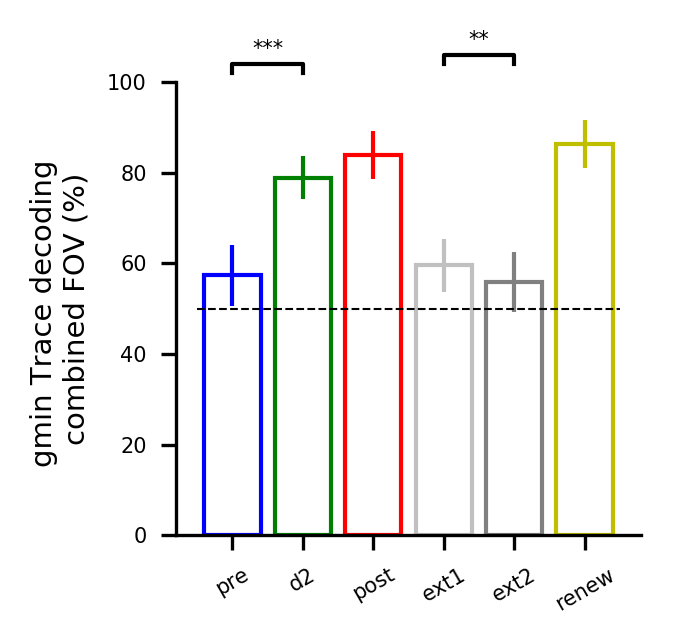

In [31]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
values = [scores_tr_gmin[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','g','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('gmin Trace decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


fig.savefig('../img/%s_tr_bars_vhpc_gmin.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s_tr_bars_vhpc_gmin.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

# now use a modified gmin of 200 cells (only dhpc pre-ext1 and pre-renew have < 200 cells)

In [41]:
scores_CS_200 = {}
n_loops = 50
for sess in sessions:
    scores_CS_200[sess] = np.r_[[do_test_within(eval("patterns_CS_%s"%sess), eval("labels_CS_%s"%sess), n_cells=200)
                          for i in range(n_loops)]]

(200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,)

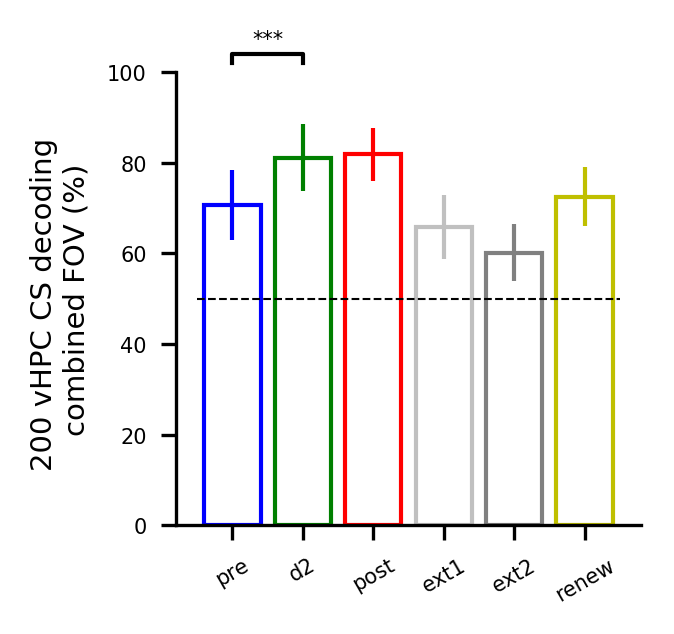

In [42]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
values = [scores_CS_200[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','g','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('200 vHPC CS decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
#pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


fig.savefig('../img/%s__bars_CS_vhpc_200.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s__bars_CS_vhpc_200.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [34]:
scores_tr_200 = {}
n_loops = 50
for sess in sessions:
    scores_tr_200[sess] = np.r_[[do_test_within(eval("patterns_tr_%s"%sess), eval("labels_tr_%s"%sess), n_cells=200)
                          for i in range(n_loops)]]

(200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,) (200,)

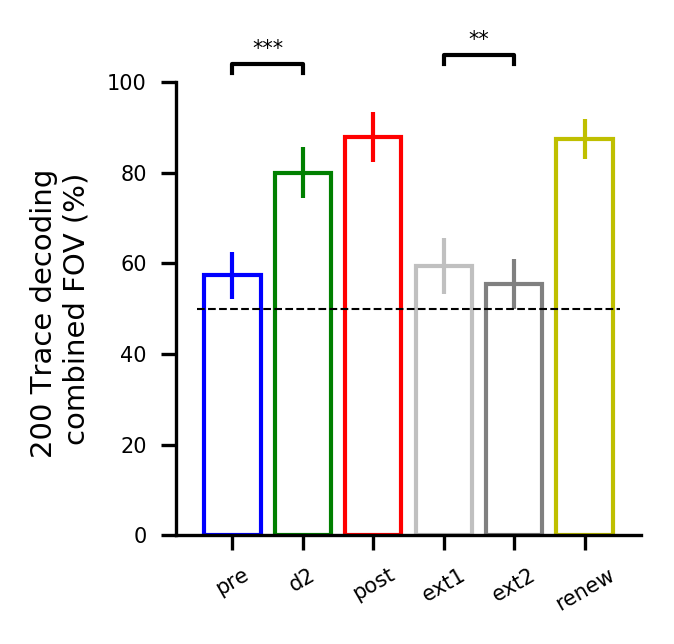

In [35]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
values = [scores_tr_200[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','g','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('200 Trace decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


fig.savefig('../img/%s_tr_bars_vhpc_200.pdf'%NOTEBOOK_NAME)
np.savetxt('../img/%s_tr_bars_vhpc_200.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [36]:
scores_CS_250 = {}
n_loops = 50
for sess in sessions:
    scores_CS_250[sess] = np.r_[[do_test_within(eval("patterns_CS_%s"%sess), eval("labels_CS_%s"%sess), n_cells=250)
                          for i in range(n_loops)]]

(250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,)

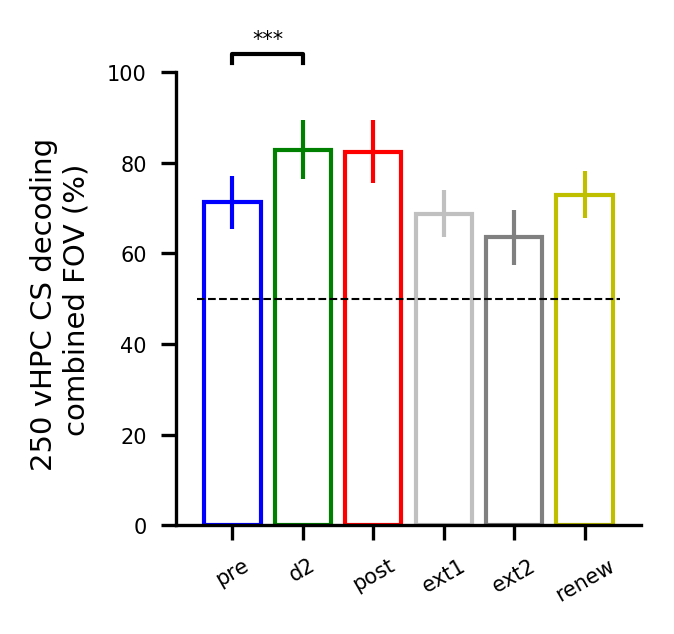

In [37]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
values = [scores_CS_250[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','g','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('250 vHPC CS decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
#pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


#fig.savefig('../img/%s__bars_CS_vhpc_250.pdf'%NOTEBOOK_NAME)
#np.savetxt('../img/%s__bars_CS_vhpc_200.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [38]:
scores_tr_250 = {}
n_loops = 50
for sess in sessions:
    scores_tr_250[sess] = np.r_[[do_test_within(eval("patterns_tr_%s"%sess), eval("labels_tr_%s"%sess), n_cells=250)
                          for i in range(n_loops)]]

(250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,) (250,)

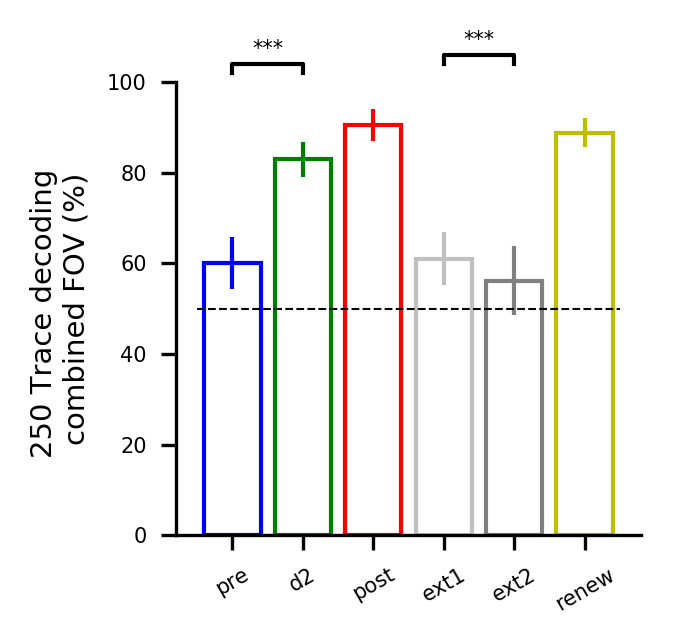

In [39]:
fig, ax = pl.subplots(1, 1, figsize=(2, 2))
values = [scores_tr_250[sess]*100 for sess in sessions]
pt.plot_bars(values, ax=ax, colors = ['b','g','r','silver','grey','y','k'])
ax.hlines(50, -0.5, len(sessions)-0.5, linestyles='dashed')

ax.set_xticks(range(6))
ax.set_xticklabels(sessions, rotation=30)
ax.set_ylabel('250 Trace decoding \ncombined FOV (%)')
ax.set_ylim(0,100)
pvs = []
pvs.append(pt.add_significance(ax, values[0], values[1], 0, 1, 104)) #will compare sessions 'x' in values[x]
#pvs.append(pt.add_significance(ax, values[1], values[2], 1, 2, 109))
#pvs.append(pt.add_significance(ax, values[2], values[3], 2, 3, 100))
pvs.append(pt.add_significance(ax, values[3], values[4], 3, 4, 106))
#pvs.append(pt.add_significance(ax, values[0], values[4], 0, 4, 120))


#fig.savefig('../img/%s_tr_bars_vhpc_250.pdf'%NOTEBOOK_NAME)
#np.savetxt('../img/%s_tr_bars_vhpc_250.pvs'%NOTEBOOK_NAME,  pvs, header='Mann-Whitney U two-sided')

In [40]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
